In [1]:
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

In [3]:
img_path = './words_captcha/'
annotation_file = './words_captcha/spec_train_val.txt'

In [4]:
img_name_vector = []
words = []

with open(annotation_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    tmp = line.split()
    img_name = tmp[0]+'.png'
    word = tmp[1]
    
    img_name_vector.append(img_path+img_name)
    words.append('<start> ' + ' '.join(list(word)) + ' <end>')

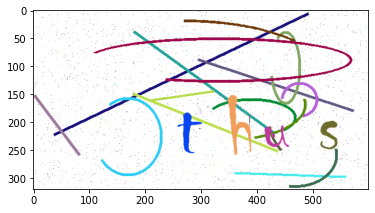

In [5]:
img = tf.io.read_file(img_path+'a0.png')
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)

In [6]:
def load_image(image_path, word):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (50, 100))
    img = img / 255.0
    return img, word

## Preprocess and tokenize captcha strings

In [7]:
def max_len(tensor):
    return max(len(t) for t in tensor)

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(words)
train_seqs = tokenizer.texts_to_sequences(words)

In [9]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [10]:
max_length = max_len(cap_vector)

## Prepare dataset

In [11]:
# Use the first 100000 captchas as training examples
num_examples = 100000

img_name_train = img_name_vector[:num_examples]
cap_train = cap_vector[:num_examples]

img_name_val = img_name_vector[num_examples:]
cap_val = cap_vector[num_examples:]

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 256
attention_features_shape = 18

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50, 100, 3]), TensorShape([64, 7]))

## Attention

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

## CNN Encoder

In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        
        layers = [
            Conv2D(96, (3, 3), padding='valid', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            Dropout(0.5)
        ]
        
        self.cnn = tf.keras.models.Sequential(layers)
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')
        
    def call(self, x):
        x = self.cnn(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        return x

## Decoder

In [17]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
# Initialize encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [19]:
sample_output = encoder(example_input_batch)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 256)


In [20]:
attention_layer = BahdanauAttention(10)

# sample_hidden shape == (BATCH_SIZE, units)
sample_hidden = decoder.reset_state(BATCH_SIZE)
attention_result, attention_weights = attention_layer(sample_output, sample_hidden)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 256)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


In [21]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_output, sample_hidden)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 29)


## Define optimizer and loss function

In [22]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Checkpoint

In [23]:
checkpoint_path = './checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [24]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

In [25]:
loss_plot = []

In [26]:
@tf.function
def train_step(images, targets):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=targets.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * targets.shape[0], 1)
    
    with tf.GradientTape() as tape:
        # features shape == (BATCH_SIZE, 18, embedding_dim)
        features = encoder(images)
        for i in range(1, targets.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(targets[:, i], predictions)
            
            # teacher forcing
            dec_input = tf.expand_dims(targets[:, i], 1)
            
    total_loss = loss / int(targets.shape[1])
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return total_loss

In [28]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (imgs, targets)) in enumerate(dataset):
        target_loss = train_step(imgs, targets)
        total_loss += target_loss
            
    loss_plot.append(total_loss/num_steps)
    
    # if epoch % 5 == 0:
    ckpt_manager.save()
    
    print('Epoch {} Loss {:.6f}'.format(epoch+1, total_loss/num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.629621
Time taken for 1 epoch 89.35545659065247 sec

Epoch 2 Loss 1.449811
Time taken for 1 epoch 76.0240044593811 sec

Epoch 3 Loss 0.757423
Time taken for 1 epoch 76.48906445503235 sec

Epoch 4 Loss 0.294935
Time taken for 1 epoch 76.76281237602234 sec

Epoch 5 Loss 0.168720
Time taken for 1 epoch 76.97261548042297 sec

Epoch 6 Loss 0.118399
Time taken for 1 epoch 76.7977454662323 sec

Epoch 7 Loss 0.093532
Time taken for 1 epoch 76.80275249481201 sec

Epoch 8 Loss 0.073851
Time taken for 1 epoch 76.65351033210754 sec

Epoch 9 Loss 0.062131
Time taken for 1 epoch 76.88526439666748 sec

Epoch 10 Loss 0.054584
Time taken for 1 epoch 76.85137104988098 sec

Epoch 11 Loss 0.048957
Time taken for 1 epoch 77.17724084854126 sec

Epoch 12 Loss 0.041335
Time taken for 1 epoch 77.0988495349884 sec

Epoch 13 Loss 0.037720
Time taken for 1 epoch 76.88800239562988 sec

Epoch 14 Loss 0.035930
Time taken for 1 epoch 76.8426296710968 sec

Epoch 15 Loss 0.031897
Time taken for 1 epoch 7

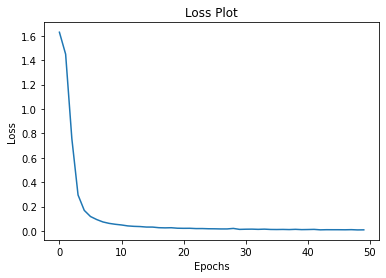

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [94]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)
    
    features = encoder(image)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        result.append(tokenizer.index_word[predicted_id])
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [109]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (3, 6))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Visualize attention

3402
Real Caption: <start>root<end>
Prediction Caption: root


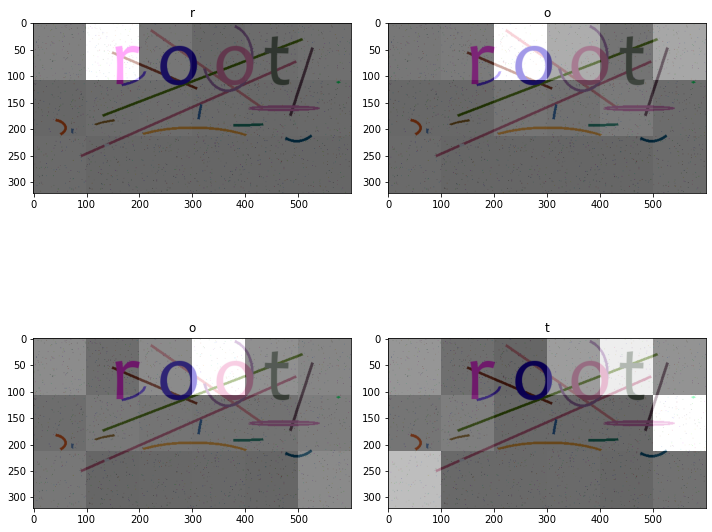

In [112]:
rid = np.random.randint(0, len(img_name_val))
print(rid)

image, caption = load_image(img_name_val[rid], cap_val[rid])
image = tf.expand_dims(image, 0)
real_caption = ''.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ''.join(result))
# Image.open(img_name_val[rid])
plot_attention(img_name_val[rid], result, attention_plot)

## Validation

In [74]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
dataset_val = dataset_val.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [75]:
predictions = []
targets = []

for (batch, (img, target)) in tqdm(enumerate(dataset_val)):
    img = tf.expand_dims(img, 0)
    result = evaluate(img)
    
    predictions.append(''.join(result))
    
    real_caption = ''.join([tokenizer.index_word[i] for i in cap_val[batch] if i not in [0, 1, 2]])
    targets.append(real_caption)

20000it [07:42, 43.24it/s]


In [76]:
print('Validation accuracy:', np.mean(np.array(predictions) == np.array(targets)))

Validation accuracy: 0.90675


## Make prediction

In [77]:
def load_test_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (50, 100))
    img = img / 255.0
    return img

In [78]:
img_name_test = []

for img_name in tqdm(os.listdir(img_path)):
    img_path_name = img_path + img_name
    if img_path_name not in img_name_vector and img_path_name != annotation_file:
        img_name_test.append(img_path_name)

100%|█████████████████████████████████| 140001/140001 [01:54<00:00, 1220.02it/s]


In [80]:
dataset_test = tf.data.Dataset.from_tensor_slices(img_name_test)
dataset_test = dataset_test.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [81]:
predictions = []

for batch, img in tqdm(enumerate(dataset_test)):
    img = tf.expand_dims(img, 0)
    result = evaluate(img)
    predictions.append(''.join(result))
    
predictions[:10]

20000it [07:41, 43.36it/s]


['toe', 'that', 'kerry', 'type', 'mba', 'line', 'von', 'means', 'pink', 'kids']

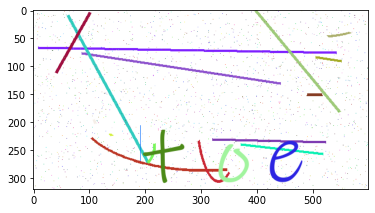

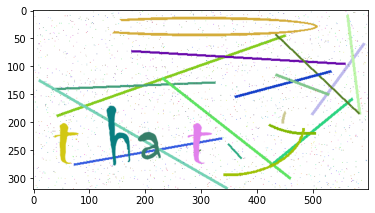

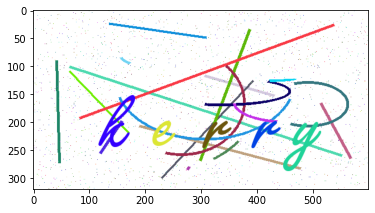

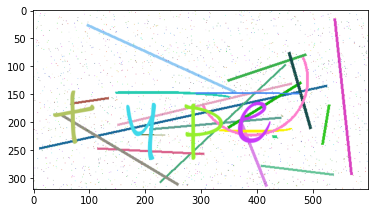

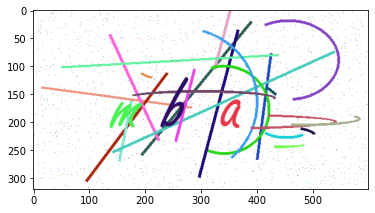

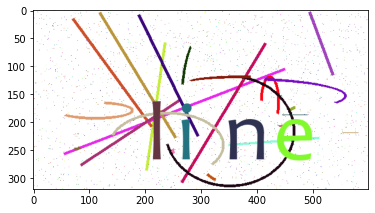

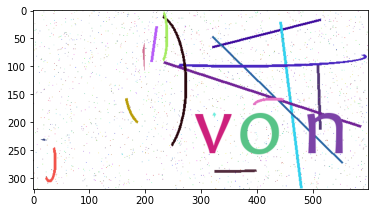

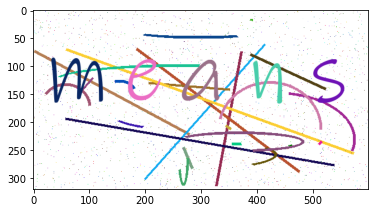

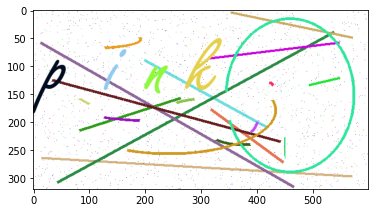

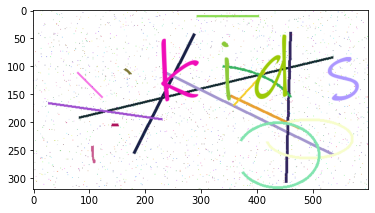

In [123]:
for img in img_name_test[:10]:
    plt.imshow(Image.open(img))
    plt.show()